In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import kagglehub


# 1-2) Image Preprocessing

In [2]:
path = kagglehub.dataset_download("prakharrastogi534/bean-leaf-dataset")

100%|██████████| 172M/172M [00:01<00:00, 179MB/s]

Extracting files...


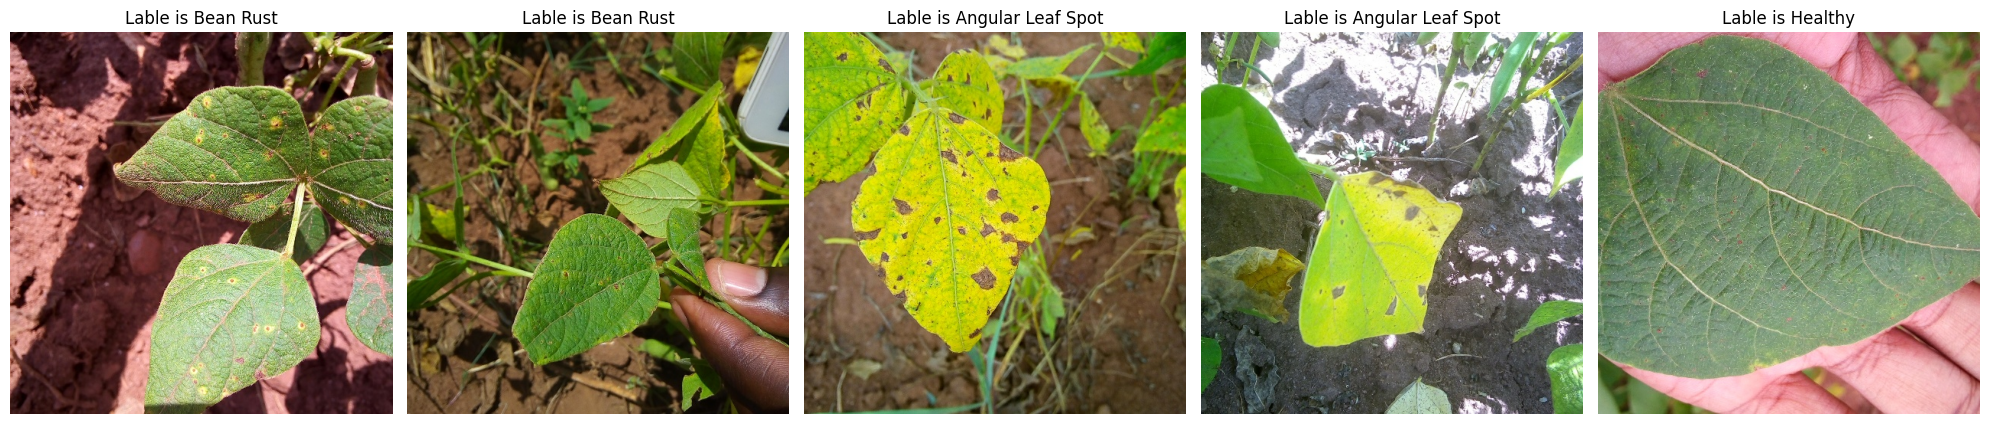

In [ ]:
# Function to get all image files from a folder and subfolders
def get_all_images(image_dir):
    image_files = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                image_files.append(os.path.join(root, file))
    return image_files


all_images = get_all_images(path)

# Randomly select 5 images from the list
random_images = random.sample(all_images, 5)

# Plotting the images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for ax, image_path in zip(axes, random_images):
    img = Image.open(image_path)
    ax.imshow(img)
    ax.axis('off')

    if "angular_leaf_spot" in image_path:
        lable = "Angular Leaf Spot"
    elif "bean_rust" in image_path:
        lable = "Bean Rust"
    elif "healthy" in image_path:
        lable = "Healthy"

    ax.set_title(f"Lable is {lable}")

plt.tight_layout()
plt.show()


# 2-2 ) Implementation

## 2-2-1) Model Implementation with Transfer Learning

In [3]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB6, NASNetMobile
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.models import load_model


# Transfer Learning
def build_transfer_model(base_model):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(3, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)


In [4]:
# MobileNetV2
base_model_mobilenet = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model_mobilenet = build_transfer_model(base_model_mobilenet)

# EfficientNetB6
base_model_efficientnet = EfficientNetB6(input_shape=(528, 528, 3), include_top=False, weights='imagenet')
model_efficientnet = build_transfer_model(base_model_efficientnet)

# NasNet
base_model_nasnet = NASNetMobile(input_shape=(331, 331, 3), include_top=False, weights='imagenet')
model_nasnet = build_transfer_model(base_model_nasnet)

19993432/19993432 [==============================] - 0s 0us/step


## 2-2-2) Data Augmentation

In [ ]:
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 kB 15.7 MB/s eta 0:00:00


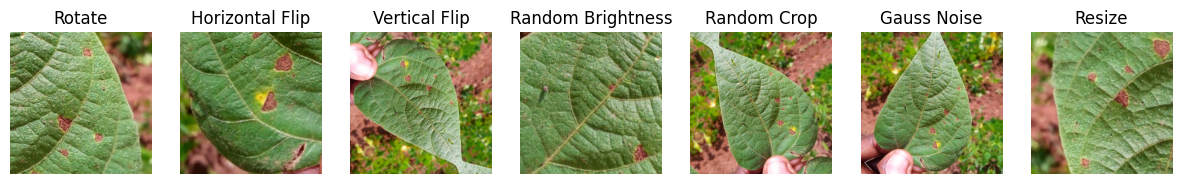

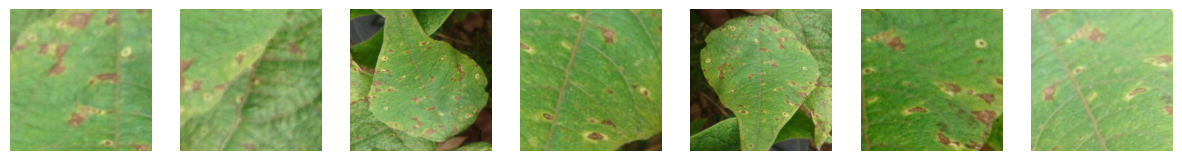

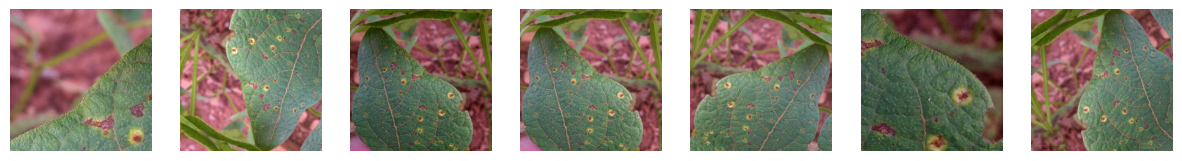

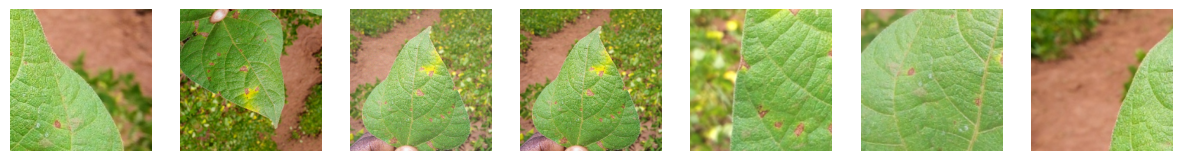

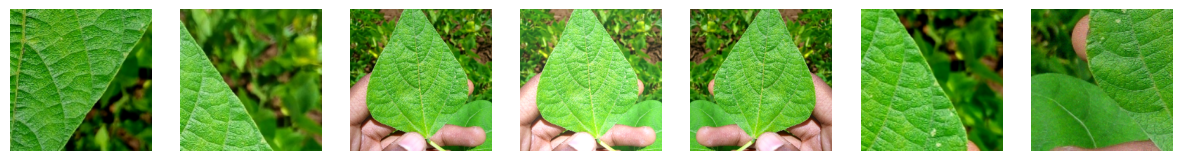

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np


transform = A.Compose([
    A.Rotate(limit=40, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomCrop(width=180, height=180, p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.3),
    A.Resize(224, 224),
    ToTensorV2()
])

augmented_title = ["Rotate", "Horizontal Flip", "Vertical Flip", "Random Brightness", "Random Crop", "Gauss Noise", "Resize"]
for j, sample_image in enumerate(random_images):
    image = cv2.imread(sample_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 7, figsize=(15, 7))

    if j == 0:
        for k in range(7):
            axs[k].set_title(augmented_title[k])

    for i in range(7):
        augmented = transform(image=image)
        aug_image = augmented['image']
        axs[i].imshow(aug_image.permute(1, 2, 0))
        axs[i].axis('off')

    plt.show()

## 2-2-3) Data Augmentation for models

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

mobile_image_size = (224, 224)
efficient_image_size = (528, 528)
nas_image_size = (331, 331)
BATCH_SIZE = 32

models = {
    "MobileNetV2": (224, 224),
    "EfficientNetB6": (528, 528),
    "NasNetMobile": (331, 331)
}


train_dir = path + "/train/train"
valid_dir = path + "/validation/validation"

data_gen = ImageDataGenerator(rescale=1./255)

train_gen = {}
valid_gen = {}

for model_name, size in models.items():
    train_gen[model_name] = data_gen.flow_from_directory(train_dir, target_size=size, batch_size=32, class_mode='categorical')
    valid_gen[model_name] = data_gen.flow_from_directory(valid_dir, target_size=size, batch_size=32, class_mode='categorical')


Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


## 2-2-4) Training with Optimizers

### MobileNetV2

In [ ]:
# MobileNetV2 with RMSprop Optimizer
model_mobilenet_rmsprop = build_transfer_model(base_model_mobilenet)
model_mobilenet_rmsprop.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenet_rmsprop = model_mobilenet_rmsprop.fit(train_gen['MobileNetV2'], validation_data=valid_gen['MobileNetV2'], epochs=25)
print(f"MobileNetV2 Validation Accuracy: {history_mobilenet_rmsprop.history['val_accuracy'][-1]:.2f}")


# Save the model after training
# model_mobilenet_rmsprop.save('mobilenetv2_rmsprop_transfer_model.h5')
model_mobilenet_rmsprop.save('mobilenetv2_rmsprop_transfer_model.keras')


Epoch 1/25
33/33 [==============================] - 11s 264ms/step - loss: 0.8080 - accuracy: 0.6634 - val_loss: 0.3765 - val_accuracy: 0.8496
Epoch 2/25
33/33 [==============================] - 7s 224ms/step - loss: 0.4115 - accuracy: 0.8356 - val_loss: 0.2849 - val_accuracy: 0.8947
Epoch 3/25
33/33 [==============================] - 7s 215ms/step - loss: 0.3105 - accuracy: 0.8801 - val_loss: 0.2838 - val_accuracy: 0.9098
Epoch 4/25
33/33 [==============================] - 7s 220ms/step - loss: 0.2540 - accuracy: 0.8936 - val_loss: 0.2678 - val_accuracy: 0.9173
Epoch 5/25
33/33 [==============================] - 8s 236ms/step - loss: 0.2394 - accuracy: 0.9052 - val_loss: 0.2484 - val_accuracy: 0.9098
Epoch 6/25
33/33 [==============================] - 8s 232ms/step - loss: 0.2009 - accuracy: 0.9284 - val_loss: 0.2247 - val_accuracy: 0.9173
Epoch 7/25
33/33 [==============================] - 8s 224ms/step - loss: 0.1583 - accuracy: 0.9410 - val_loss: 0.2824 - val_accuracy: 0.9323
Epoch

In [ ]:
# MobileNetV2 with Adam Optimizer
model_mobilenet_adam = build_transfer_model(base_model_mobilenet)
model_mobilenet_adam.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenet_adam = model_mobilenet_adam.fit(train_gen['MobileNetV2'], validation_data=valid_gen['MobileNetV2'], epochs=25)
print(f"MobileNetV2 Validation Accuracy: {history_mobilenet_adam.history['val_accuracy'][-1]:.2f}")


# Save the model after training
# model_mobilenet_adam.save('mobilenetv2_adam_transfer_model.h5')
model_mobilenet_adam.save('mobilenetv2_adam_transfer_model.keras')

Epoch 1/25
33/33 [==============================] - 11s 270ms/step - loss: 0.6578 - accuracy: 0.7147 - val_loss: 0.3601 - val_accuracy: 0.8722
Epoch 2/25
33/33 [==============================] - 8s 232ms/step - loss: 0.3849 - accuracy: 0.8511 - val_loss: 0.2938 - val_accuracy: 0.9173
Epoch 3/25
33/33 [==============================] - 8s 224ms/step - loss: 0.2792 - accuracy: 0.8926 - val_loss: 0.3192 - val_accuracy: 0.9173
Epoch 4/25
33/33 [==============================] - 8s 243ms/step - loss: 0.2382 - accuracy: 0.9091 - val_loss: 0.2469 - val_accuracy: 0.9023
Epoch 5/25
33/33 [==============================] - 8s 231ms/step - loss: 0.1893 - accuracy: 0.9313 - val_loss: 0.2294 - val_accuracy: 0.9248
Epoch 6/25
33/33 [==============================] - 8s 233ms/step - loss: 0.1555 - accuracy: 0.9439 - val_loss: 0.2387 - val_accuracy: 0.9173
Epoch 7/25
33/33 [==============================] - 8s 232ms/step - loss: 0.1299 - accuracy: 0.9526 - val_loss: 0.2334 - val_accuracy: 0.9323
Epoch

In [ ]:
# MobileNetV2 with Nadam Optimizer
model_mobilenet_nadam = build_transfer_model(base_model_mobilenet)
model_mobilenet_nadam.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenet_nadam = model_mobilenet_nadam.fit(train_gen['MobileNetV2'], validation_data=valid_gen['MobileNetV2'], epochs=25)
print(f"MobileNetV2 Validation Accuracy: {history_mobilenet_nadam.history['val_accuracy'][-1]:.2f}")


# Save the model after training
# model_mobilenet_nadam.save('mobilenetv2_nadam_transfer_model.h5')
model_mobilenet_nadam.save('mobilenetv2_nadam_transfer_model.keras')

Epoch 1/25
33/33 [==============================] - 13s 276ms/step - loss: 0.7083 - accuracy: 0.6934 - val_loss: 0.3707 - val_accuracy: 0.8571
Epoch 2/25
33/33 [==============================] - 8s 243ms/step - loss: 0.3816 - accuracy: 0.8501 - val_loss: 0.3011 - val_accuracy: 0.8797
Epoch 3/25
33/33 [==============================] - 8s 238ms/step - loss: 0.2747 - accuracy: 0.9072 - val_loss: 0.2550 - val_accuracy: 0.9173
Epoch 4/25
33/33 [==============================] - 8s 236ms/step - loss: 0.2083 - accuracy: 0.9275 - val_loss: 0.2462 - val_accuracy: 0.9023
Epoch 5/25
33/33 [==============================] - 8s 239ms/step - loss: 0.1662 - accuracy: 0.9468 - val_loss: 0.2313 - val_accuracy: 0.9098
Epoch 6/25
33/33 [==============================] - 7s 221ms/step - loss: 0.1409 - accuracy: 0.9545 - val_loss: 0.2607 - val_accuracy: 0.9098
Epoch 7/25
33/33 [==============================] - 8s 223ms/step - loss: 0.1173 - accuracy: 0.9632 - val_loss: 0.2488 - val_accuracy: 0.9173
Epoch

### EfficientNetB6

In [ ]:
# EfficientNetB6 with RMSprop Optimizer
model_efficientnet_rmsprop = build_transfer_model(base_model_efficientnet)
model_efficientnet_rmsprop.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_efficientnet_rmsprop = model_efficientnet_rmsprop.fit(train_gen['EfficientNetB6'], validation_data=valid_gen['EfficientNetB6'], epochs=25)
print(f"EfficientNetB6 Validation Accuracy: {history_efficientnet_rmsprop.history['val_accuracy'][-1]:.2f}")


# Save the model after training
# model_efficientnet_rmsprop.save('efficientnetb6_rmsprop_transfer_model.h5')
model_efficientnet_rmsprop.save('efficientnetb6_rmsprop_transfer_model.keras')

Epoch 1/25
33/33 [==============================] - 366s 11s/step - loss: 1.1198 - accuracy: 0.3443 - val_loss: 1.1015 - val_accuracy: 0.3308
Epoch 2/25
33/33 [==============================] - 345s 10s/step - loss: 1.1002 - accuracy: 0.3056 - val_loss: 1.0986 - val_accuracy: 0.3308
Epoch 3/25
33/33 [==============================] - 344s 10s/step - loss: 1.0987 - accuracy: 0.3201 - val_loss: 1.0986 - val_accuracy: 0.3308
Epoch 4/25
33/33 [==============================] - 346s 11s/step - loss: 1.0987 - accuracy: 0.3191 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 5/25
33/33 [==============================] - 346s 11s/step - loss: 1.0987 - accuracy: 0.3027 - val_loss: 1.0986 - val_accuracy: 0.3308
Epoch 6/25
33/33 [==============================] - 346s 11s/step - loss: 1.0987 - accuracy: 0.3240 - val_loss: 1.0986 - val_accuracy: 0.3308
Epoch 7/25
33/33 [==============================] - 348s 11s/step - loss: 1.0987 - accuracy: 0.3279 - val_loss: 1.0986 - val_accuracy: 0.3308
Epoch 

In [ ]:
# EfficientNetB6 with Adam Optimizer
model_efficientnet_adam = build_transfer_model(base_model_efficientnet)
model_efficientnet_adam.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
history_efficientnet_adam = model_efficientnet_adam.fit(train_gen['EfficientNetB6'], validation_data=valid_gen['EfficientNetB6'], epochs=25)
print(f"EfficientNetB6 Validation Accuracy: {history_efficientnet_adam.history['val_accuracy'][-1]:.2f}")


# Save the model after training
# model_efficientnet_adam.save('efficientnetb6_adam_transfer_model.h5')
model_efficientnet_adam.save('efficientnetb6_adam_transfer_model.keras')

Epoch 1/25
33/33 [==============================] - 396s 12s/step - loss: 1.1207 - accuracy: 0.3356 - val_loss: 1.0993 - val_accuracy: 0.3308
Epoch 2/25
33/33 [==============================] - 369s 11s/step - loss: 1.0991 - accuracy: 0.3414 - val_loss: 1.0988 - val_accuracy: 0.3308
Epoch 3/25
33/33 [==============================] - 364s 11s/step - loss: 1.1036 - accuracy: 0.3191 - val_loss: 1.0988 - val_accuracy: 0.3383
Epoch 4/25
33/33 [==============================] - 362s 11s/step - loss: 1.0996 - accuracy: 0.3211 - val_loss: 1.0982 - val_accuracy: 0.3308
Epoch 5/25
33/33 [==============================] - ETA: 0s - loss: 1.0983 - accuracy: 0.3337

In [ ]:
# EfficientNetB6 with Nadam Optimizer
model_efficientnet_nadam = build_transfer_model(base_model_efficientnet)
model_efficientnet_nadam.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_efficientnet_nadam = model_efficientnet_nadam.fit(train_gen['EfficientNetB6'], validation_data=valid_gen['EfficientNetB6'], epochs=25)
print(f"EfficientNetB6 Validation Accuracy: {history_efficientnet_nadam.history['val_accuracy'][-1]:.2f}")


# Save the model after training
# model_efficientnet_nadam.save('efficientnetb6_nadam_transfer_model.h5')
model_efficientnet_nadam.save('efficientnetb6_nadam_transfer_model.keras')

### NasNet

In [ ]:
# NasNet with RMSprop Optimizer
model_nasnet_rmsprop = build_transfer_model(base_model_nasnet)
model_nasnet_rmsprop.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_nasnet_rmsprop = model_nasnet_rmsprop.fit(train_gen['NasNetMobile'], validation_data=valid_gen['NasNetMobile'], epochs=25)
print(f"NasNetMobile Validation Accuracy: {history_nasnet_rmsprop.history['val_accuracy'][-1]:.2f}")


# Save the model after training
# model_nasnet_rmsprop.save('nasnet_rmsprop_transfer_model.h5')
model_nasnet_rmsprop.save('nasnet_rmsprop_transfer_model.keras')

Epoch 1/25
33/33 [==============================] - 39s 847ms/step - loss: 0.7367 - accuracy: 0.6770 - val_loss: 0.6145 - val_accuracy: 0.7143
Epoch 2/25
33/33 [==============================] - 21s 633ms/step - loss: 0.5866 - accuracy: 0.7524 - val_loss: 0.5026 - val_accuracy: 0.7895
Epoch 3/25
33/33 [==============================] - 22s 659ms/step - loss: 0.5016 - accuracy: 0.7911 - val_loss: 0.4819 - val_accuracy: 0.7970
Epoch 4/25
33/33 [==============================] - 22s 684ms/step - loss: 0.4532 - accuracy: 0.8240 - val_loss: 0.4219 - val_accuracy: 0.8496
Epoch 5/25
33/33 [==============================] - 23s 700ms/step - loss: 0.4348 - accuracy: 0.8298 - val_loss: 0.4212 - val_accuracy: 0.8421
Epoch 6/25
33/33 [==============================] - 24s 743ms/step - loss: 0.3627 - accuracy: 0.8588 - val_loss: 0.3967 - val_accuracy: 0.8271
Epoch 7/25
33/33 [==============================] - 23s 702ms/step - loss: 0.3556 - accuracy: 0.8559 - val_loss: 0.4048 - val_accuracy: 0.8496

In [ ]:
# NasNet with Adam Optimizer
model_nasnet_adam = build_transfer_model(base_model_nasnet)
model_nasnet_adam.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_nasnet_adam = model_nasnet_adam.fit(train_gen['NasNetMobile'], validation_data=valid_gen['NasNetMobile'], epochs=25)
print(f"NasNetMobile Validation Accuracy: {history_nasnet_adam.history['val_accuracy'][-1]:.2f}")


# Save the model after training
# history_nasnet_adam.save('nasnet_adam_transfer_model.h5')
model_nasnet_adam.save('nasnet_adam_transfer_model.keras')

Epoch 1/25
33/33 [==============================] - 37s 767ms/step - loss: 0.8154 - accuracy: 0.6393 - val_loss: 0.6103 - val_accuracy: 0.7368
Epoch 2/25
33/33 [==============================] - 22s 672ms/step - loss: 0.6003 - accuracy: 0.7495 - val_loss: 0.5127 - val_accuracy: 0.8195
Epoch 3/25
33/33 [==============================] - 21s 647ms/step - loss: 0.5054 - accuracy: 0.7988 - val_loss: 0.4650 - val_accuracy: 0.8496
Epoch 4/25
33/33 [==============================] - 22s 662ms/step - loss: 0.4512 - accuracy: 0.8308 - val_loss: 0.4535 - val_accuracy: 0.8421
Epoch 5/25
33/33 [==============================] - 19s 582ms/step - loss: 0.4126 - accuracy: 0.8346 - val_loss: 0.4106 - val_accuracy: 0.8797
Epoch 6/25
33/33 [==============================] - 22s 674ms/step - loss: 0.3769 - accuracy: 0.8636 - val_loss: 0.4017 - val_accuracy: 0.8571
Epoch 7/25
33/33 [==============================] - 22s 682ms/step - loss: 0.3463 - accuracy: 0.8665 - val_loss: 0.4007 - val_accuracy: 0.8346

AttributeError: 'History' object has no attribute 'save'

In [ ]:
# NasNet with Nadam Optimizer
model_nasnet_nadam = build_transfer_model(base_model_nasnet)
model_nasnet_nadam.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_nasnet_nadam = model_nasnet_nadam.fit(train_gen['NasNetMobile'], validation_data=valid_gen['NasNetMobile'], epochs=25)
print(f"NasNetMobile Validation Accuracy: {history_nasnet_nadam.history['val_accuracy'][-1]:.2f}")


# Save the model after training
# model_nasnet_nadam.save('nasnet_nadam_transfer_model.h5')
model_nasnet_nadam.save('nasnet_nadam_transfer_model.keras')

Epoch 1/25
33/33 [==============================] - 38s 778ms/step - loss: 0.8071 - accuracy: 0.6605 - val_loss: 0.6000 - val_accuracy: 0.7820
Epoch 2/25
33/33 [==============================] - 22s 670ms/step - loss: 0.5756 - accuracy: 0.7611 - val_loss: 0.5014 - val_accuracy: 0.8120
Epoch 3/25
33/33 [==============================] - 21s 642ms/step - loss: 0.4837 - accuracy: 0.8027 - val_loss: 0.4558 - val_accuracy: 0.8496
Epoch 4/25
33/33 [==============================] - 21s 632ms/step - loss: 0.4179 - accuracy: 0.8375 - val_loss: 0.4336 - val_accuracy: 0.8571
Epoch 5/25
33/33 [==============================] - 20s 604ms/step - loss: 0.3687 - accuracy: 0.8588 - val_loss: 0.4292 - val_accuracy: 0.8496
Epoch 6/25
33/33 [==============================] - 21s 636ms/step - loss: 0.3417 - accuracy: 0.8772 - val_loss: 0.3944 - val_accuracy: 0.8797
Epoch 7/25
33/33 [==============================] - 21s 637ms/step - loss: 0.3070 - accuracy: 0.8820 - val_loss: 0.3984 - val_accuracy: 0.8722

In [ ]:
import pickle

with open('/content/history_nasnet_nadam', 'wb') as file_pi:
    pickle.dump(history_nasnet_nadam.history, file_pi)


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
history_mobilenet_rmsprop = load_model('/content/mobilenetv2_rmsprop_transfer_model.keras')
# history_mobilenet_adam = load_model('/content/mobilenetv2_adam_transfer_model.keras')
# history_mobilenet_nadam = load_model('/content/mobilenetv2_nadam_transfer_model.keras')

# Print model summary to verify it loaded correctly
history_mobilenet_rmsprop.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
def show_summraies(history, title):
    print(f'Summraies for {title}')
    print(f"Training Accuracy: {(history.history['accuracy'][-1] * 100):.2f}")
    print(f"Validation Accuracy: {(history.history['val_accuracy'][-1] * 100):.2f}")
    print(f"Training Loss: {(history.history['loss'][-1] * 100):.2f}")
    print(f"Validation Loss: {(history.history['val_loss'][-1] * 100):.2f}")


# show_summraies(history_mobilenet_rmsprop, "MobileNetV2 with optimizer RMSprop")
# show_summraies(history_mobilenet_adam, "MobileNetV2 with optimizer Adam")
# show_summraies(history_mobilenet_nadam, "MobileNetV2 with optimizer Nadam")

show_summraies(history_nasnet_rmsprop, "NasNet with optimizer RMSprop")
show_summraies(history_nasnet_adam, "NasNet with optimizer Adam")
show_summraies(history_nasnet_nadam, "NasNet with optimizer Nadam")

# print("Results:")
# for model_name, optim_results in results.items():
#     for opt_name, val_acc in optim_results.items():
#         print(f"{model_name} with {opt_name} optimizer: Validation Accuracy = {(val_acc * 100):.2f}")


Summraies for NasNet with optimizer RMSprop
Training Accuracy: 95.36
Validation Accuracy: 87.22
Training Loss: 12.57
Validation Loss: 36.78
Summraies for NasNet with optimizer Adam
Training Accuracy: 95.65
Validation Accuracy: 85.71
Training Loss: 12.39
Validation Loss: 42.10
Summraies for NasNet with optimizer Nadam
Training Accuracy: 98.55
Validation Accuracy: 87.22
Training Loss: 7.92
Validation Loss: 36.20


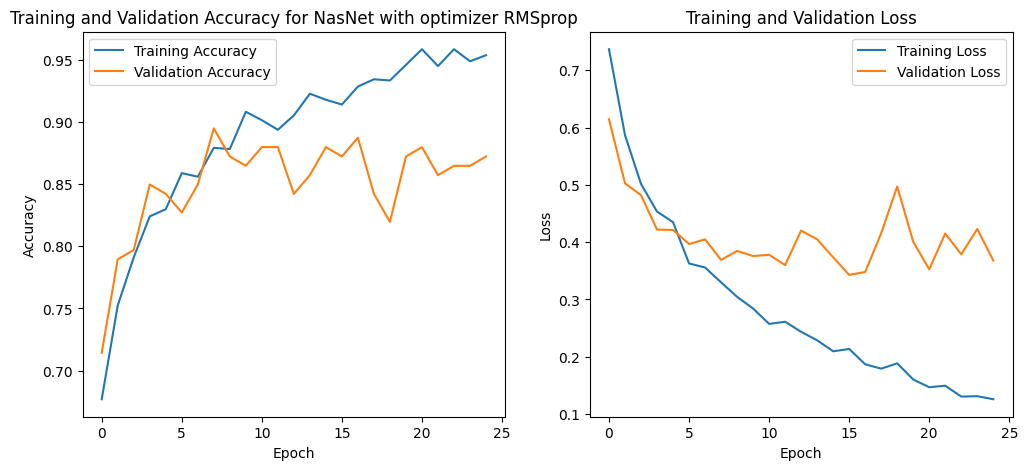

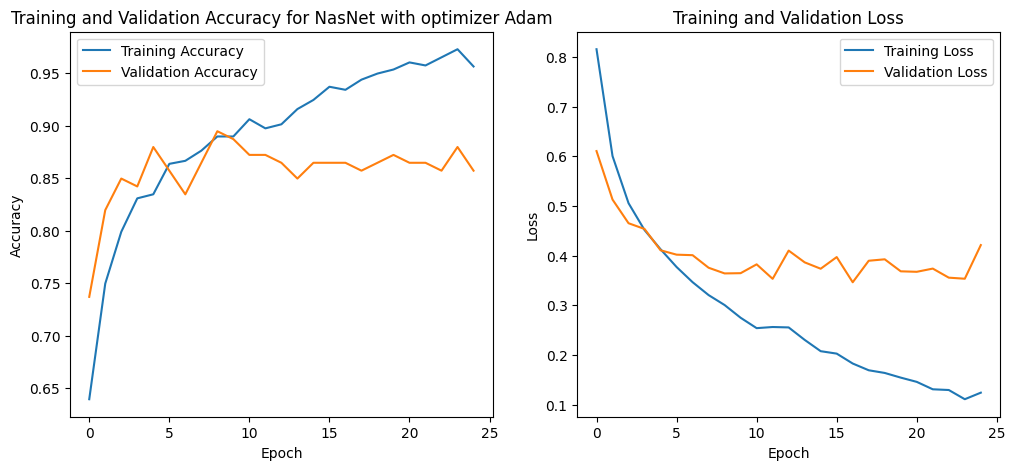

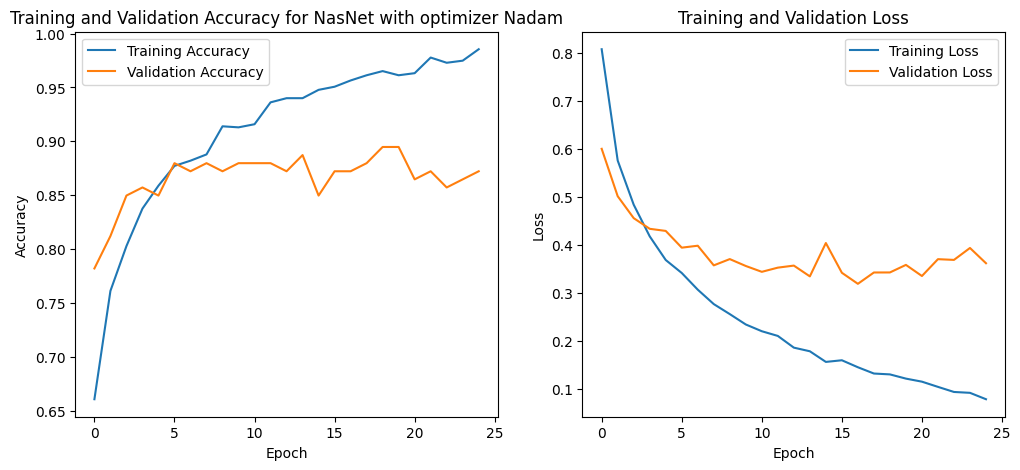

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model


# base_model_one = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# base_model_one.trainable = False
# x = base_model_one.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.3)(x)
# x = Dense(64, activation='relu')(x)
# output = Dense(3, activation='softmax')(x)
# model = Model(inputs=base_model_one.input, outputs=output)

# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# history = model.fit(train_gen['NasNetMobile'], validation_data=valid_gen['NasNetMobile'], epochs=25, batch_size=32, callbacks=[early_stopping])

# eval_results = model.evaluate(valid_gen['NasNetMobile'], batch_size=32)
# print(f"Evaluation Loss: {eval_results[0]:.4f}")
# print(f"Evaluation Accuracy: {eval_results[1]:.4f}")


def plot_metrics(history, title):
    # نمودار دقت
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Training and Validation Accuracy for {title}')

    # نمودار تابع هزینه
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# plot_metrics(history_mobilenet_rmsprop, "MobileNetV2 with optimizer RMSprop")
# plot_metrics(history_mobilenet_adam, "MobileNetV2 with optimizer Adam")
# plot_metrics(history_mobilenet_nadam, "MobileNetV2 with optimizer Nadam")

plot_metrics(history_nasnet_rmsprop, "NasNet with optimizer RMSprop")
plot_metrics(history_nasnet_adam, "NasNet with optimizer Adam")
plot_metrics(history_nasnet_nadam, "NasNet with optimizer Nadam")



In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


base_model_one = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model_one.trainable = False
x = base_model_one.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model_one.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_gen['NasNetMobile'], validation_data=valid_gen['NasNetMobile'], epochs=25, batch_size=32, callbacks=[early_stopping])

eval_results = model.evaluate(valid_gen['NasNetMobile'], batch_size=32)
print(f"Evaluation Loss: {eval_results[0]:.4f}")
print(f"Evaluation Accuracy: {eval_results[1]:.4f}")


1/1 [==============================] - 4s 4s/step


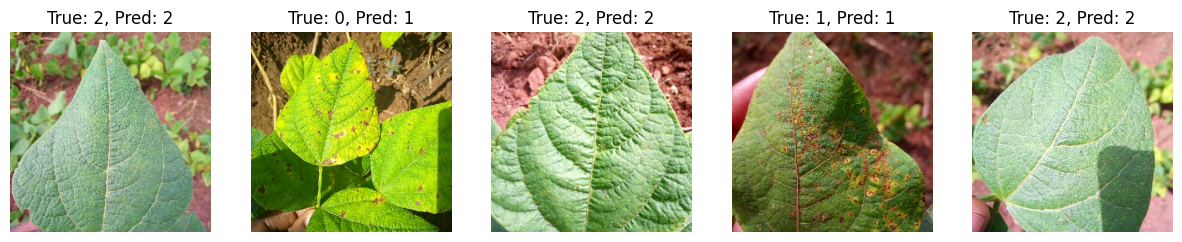

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# دریافت نمونه‌هایی از داده‌های ارزیابی
def display_evaluation_samples(model, data_gen, num_samples=5):
    images, true_labels = next(data_gen)  # تصاویر و برچسب‌های واقعی
    predictions = model.predict(images)  # پیش‌بینی مدل
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)

    # نمایش تصاویر با برچسب واقعی و پیش‌بینی‌شده
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.axis('off')
    plt.show()

# نمایش نمونه‌ها برای MobileNetV2
display_evaluation_samples(model_nasnet_adam, valid_gen['NasNetMobile'])


In [ ]:
display_evaluation_samples(model_nasnet_rmsprop, valid_gen['NasNetMobile'])